In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio

# Install tensorflow if you haven't already
#!pip install tensorflow

import tensorflow as tf # Import tensorflow

# Import keras layers and models from tensorflow.keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM,BatchNormalization , GRU
# Import Tokenizer from tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD




In [2]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,370 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,731 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [3]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!unzip -q ravdess-emotional-speech-audio.zip -d ravdess_data
!kaggle datasets download -d mostafaabdlhamed/speech-signal-features
!unzip speech-signal-features.zip -d "/content/Speech_Signal_Features"
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee
!unzip surrey-audiovisual-expressed-emotion-savee.zip -d "/content/SAVEE"
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!unzip toronto-emotional-speech-set-tess.zip -d "/content/TESS"
!kaggle datasets download -d ejlok1/cremad
!unzip cremad.zip -d "/content/CREMA-D"


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/CREMA-D/AudioWAV/1031_DFA_DIS_XX.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_DFA_FEA_XX.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_DFA_HAP_XX.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_DFA_NEU_XX.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_DFA_SAD_XX.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_IEO_ANG_HI.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_IEO_ANG_LO.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_IEO_ANG_MD.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_IEO_DIS_HI.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_IEO_DIS_LO.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_IEO_DIS_MD.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_IEO_FEA_HI.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_IEO_FEA_LO.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_IEO_FEA_MD.wav  
  inflating: /content/CREMA-D/AudioWAV/1031_IEO_HAP_HI.wav  
  inflating: /content/CREMA-

In [5]:
ravdess = "/content/ravdess_data/audio_speech_actors_01-24/"
Crema = "/content/CREMA-D/AudioWAV"
Tess = "/content/TESS/TESS Toronto emotional speech set data"
Savee = "/content/SAVEE/ALL"

In [6]:
ravdess_directory_list = os.listdir(ravdess) # Get the list of directories within the ravdess dataset path


In [7]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    actor = os.listdir('/content/ravdess_data/' + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [8]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
ravdess_df
print(ravdess_df.Emotions.value_counts())

Emotions
neutral     288
happy       192
fear        192
angry       192
disgust     192
surprise    192
sad         192
Name: count, dtype: int64


<ipython-input-8-0056d6328ba4>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


In [9]:
crema_directory_list = os.listdir(Crema)
file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append('/content/CREMA-D/AudioWAV/' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()


,Emotions,Path
0,angry,/content/CREMA-D/AudioWAV/1006_IEO_ANG_MD.wav
1,neutral,/content/CREMA-D/AudioWAV/1008_TIE_NEU_XX.wav
2,neutral,/content/CREMA-D/AudioWAV/1051_IOM_NEU_XX.wav
3,happy,/content/CREMA-D/AudioWAV/1035_IEO_HAP_MD.wav
4,sad,/content/CREMA-D/AudioWAV/1015_WSI_SAD_XX.wav


In [10]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir('/content/TESS/TESS Toronto emotional speech set data/' + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append('/content/TESS/TESS Toronto emotional speech set data/' + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,neutral,/content/TESS/TESS Toronto emotional speech se...
1,neutral,/content/TESS/TESS Toronto emotional speech se...
2,neutral,/content/TESS/TESS Toronto emotional speech se...
3,neutral,/content/TESS/TESS Toronto emotional speech se...
4,neutral,/content/TESS/TESS Toronto emotional speech se...


In [11]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append('/content/SAVEE/ALL/' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,disgust,/content/SAVEE/ALL/DC_d09.wav
1,happy,/content/SAVEE/ALL/JK_h12.wav
2,neutral,/content/SAVEE/ALL/JK_n11.wav
3,sad,/content/SAVEE/ALL/KL_sa03.wav
4,sad,/content/SAVEE/ALL/JE_sa01.wav


In [12]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path

,Emotions,Path
0,fear,/content/ravdess_data/audio_speech_actors_01-2...
1,happy,/content/ravdess_data/audio_speech_actors_01-2...
2,angry,/content/ravdess_data/audio_speech_actors_01-2...
3,disgust,/content/ravdess_data/audio_speech_actors_01-2...
4,fear,/content/ravdess_data/audio_speech_actors_01-2...
...,...,...
2795,disgust,/content/TESS/TESS Toronto emotional speech se...
2796,disgust,/content/TESS/TESS Toronto emotional speech se...
2797,disgust,/content/TESS/TESS Toronto emotional speech se...
2798,disgust,/content/TESS/TESS Toronto emotional speech se...


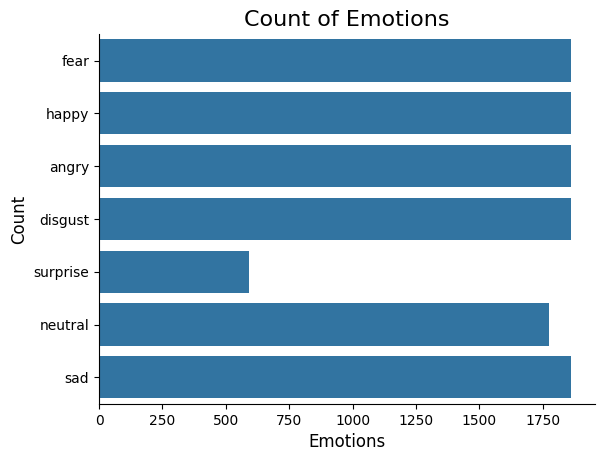

In [13]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [14]:
data,sr = librosa.load(file_path[300])
ipd.Audio(data,rate=sr)

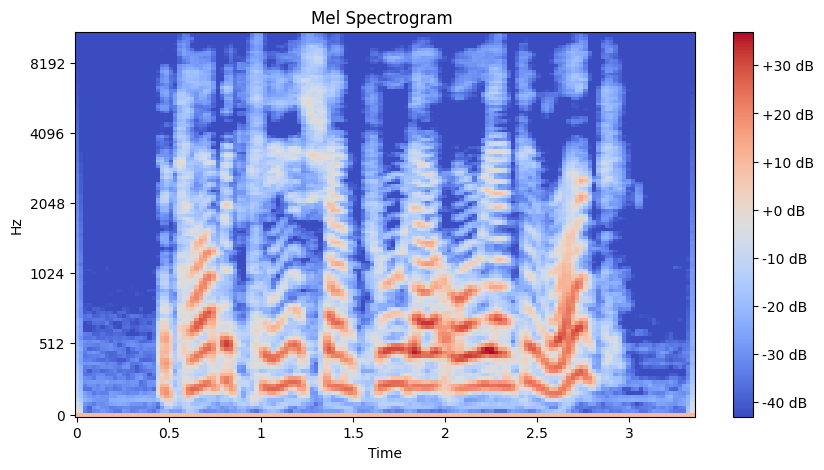

In [15]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

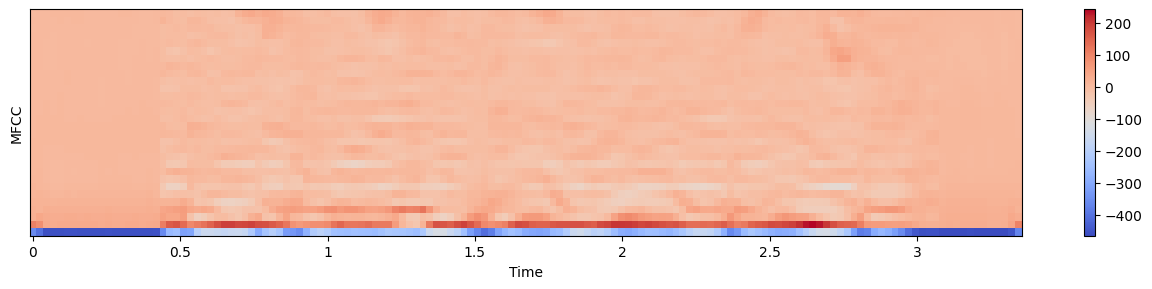

In [16]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)
# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

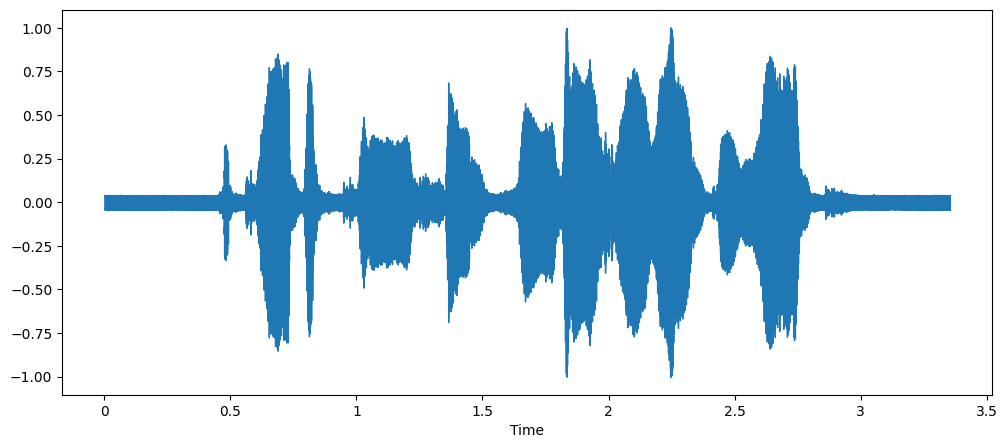

In [17]:

plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

In [18]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

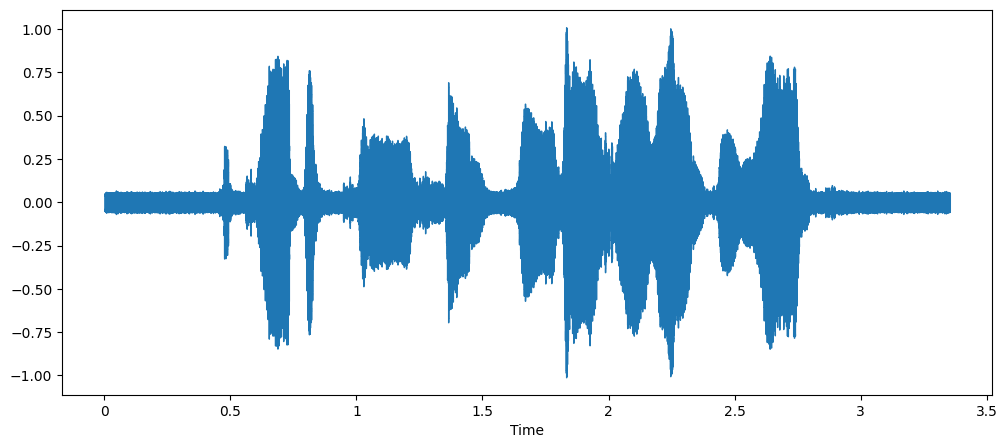

In [19]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

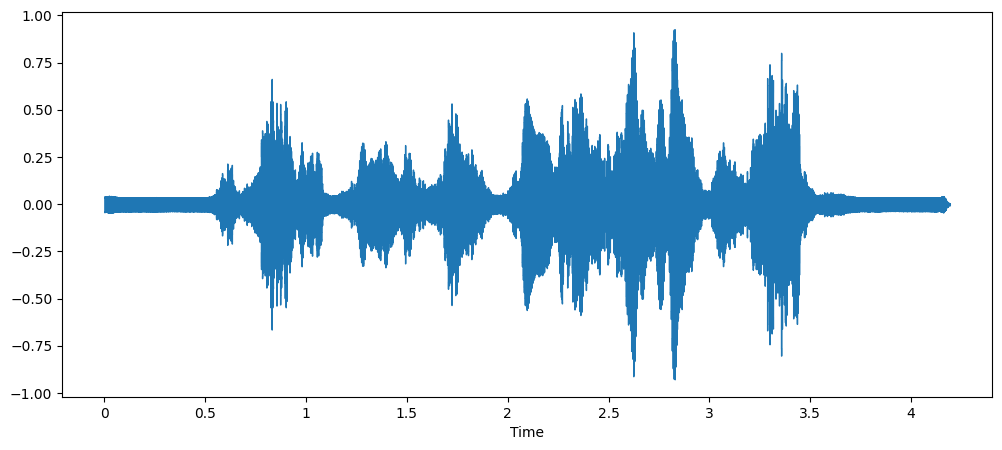

In [20]:
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
plt.show()
ipd.Audio(x, rate=sr)

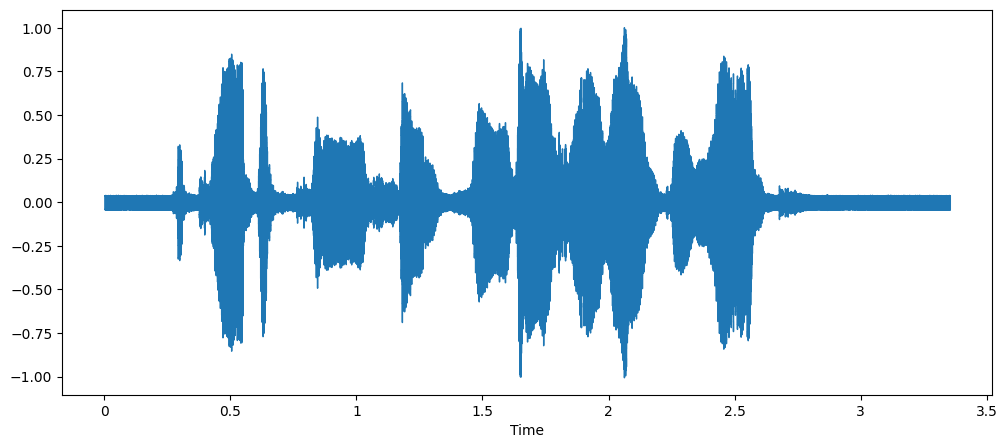

In [21]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

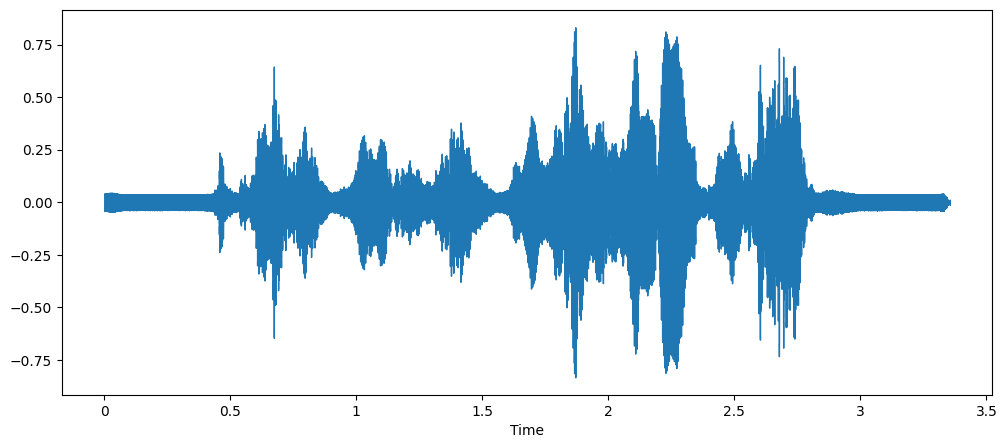

In [22]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [23]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc_feature(data,sr,frame_length=2048,hop_length=512,flatten:bool=True): # Changed the function name to mfcc_feature
    mfcc=librosa.feature.mfcc(y=data,sr=sr) # Now this calls the librosa function
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc_feature(data,sr,frame_length,hop_length) # Calling the renamed function
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [24]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  4.92it/s]

0 audio has been processed


502it [01:31,  6.39it/s]

500 audio has been processed


1002it [03:04,  6.16it/s]

1000 audio has been processed


1502it [04:33,  8.33it/s]

1500 audio has been processed


2001it [05:46,  3.94it/s]

2000 audio has been processed


2501it [07:00,  7.70it/s]

2500 audio has been processed


3002it [08:12,  7.35it/s]

3000 audio has been processed


3502it [09:33,  7.40it/s]

3500 audio has been processed


4003it [10:50,  8.47it/s]

4000 audio has been processed


4501it [12:03,  4.88it/s]

4500 audio has been processed


5002it [13:16,  7.89it/s]

5000 audio has been processed


5502it [14:29,  8.86it/s]

5500 audio has been processed


6002it [15:41,  8.67it/s]

6000 audio has been processed


6502it [16:53,  7.74it/s]

6500 audio has been processed


7002it [18:06,  5.28it/s]

7000 audio has been processed


7502it [19:21,  7.43it/s]

7500 audio has been processed


8001it [20:33,  8.25it/s]

8000 audio has been processed


8501it [21:47,  7.60it/s]

8500 audio has been processed


9002it [22:58,  9.97it/s]

9000 audio has been processed


9501it [23:58,  4.08it/s]

9500 audio has been processed


10003it [24:58, 11.81it/s]

10000 audio has been processed


10502it [26:00, 12.96it/s]

10500 audio has been processed


11003it [26:49, 10.01it/s]

11000 audio has been processed


11502it [27:50,  7.11it/s]

11500 audio has been processed


11682it [28:18,  6.88it/s]

Done
Time:  1698.3122323040002


In [25]:
len(X), len(Y), data_path.Path.shape

(46728, 46728, (11682,))

In [26]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.143555,0.214844,0.291504,0.296875,0.295898,0.290527,0.291016,0.290039,0.310059,0.344238,...,-14.715597,9.713535,0.436812,-3.947294,1.560015,-7.707618,-0.193990,1.369982,3.427481,fear
1,0.256836,0.372070,0.505859,0.514648,0.492676,0.499512,0.486328,0.468750,0.467773,0.474609,...,0.979946,4.397245,7.186375,2.863967,-2.043697,-6.572648,3.321197,3.020897,0.821385,fear
2,0.137207,0.210449,0.281250,0.281738,0.284180,0.284180,0.282715,0.286621,0.286621,0.293945,...,-4.877291,17.349869,5.182573,3.784117,-1.377720,-7.699809,3.219555,5.098877,-2.662051,fear
3,0.251465,0.377930,0.491699,0.489258,0.480957,0.481445,0.494629,0.506348,0.511230,0.518066,...,-0.655960,3.299738,2.488119,4.325253,3.385378,1.953237,-0.400083,-2.081155,1.065807,fear
4,0.241211,0.317871,0.396484,0.302734,0.309082,0.312988,0.311035,0.310547,0.297363,0.260254,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy


In [27]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.143555,0.214844,0.291504,0.296875,0.295898,0.290527,0.291016,0.290039,0.310059,0.344238,...,-14.715597,9.713535,0.436812,-3.947294,1.560015,-7.707618,-0.193990,1.369982,3.427481,fear
1,0.256836,0.372070,0.505859,0.514648,0.492676,0.499512,0.486328,0.468750,0.467773,0.474609,...,0.979946,4.397245,7.186375,2.863967,-2.043697,-6.572648,3.321197,3.020897,0.821385,fear
2,0.137207,0.210449,0.281250,0.281738,0.284180,0.284180,0.282715,0.286621,0.286621,0.293945,...,-4.877291,17.349869,5.182573,3.784117,-1.377720,-7.699809,3.219555,5.098877,-2.662051,fear
3,0.251465,0.377930,0.491699,0.489258,0.480957,0.481445,0.494629,0.506348,0.511230,0.518066,...,-0.655960,3.299738,2.488119,4.325253,3.385378,1.953237,-0.400083,-2.081155,1.065807,fear
4,0.241211,0.317871,0.396484,0.302734,0.309082,0.312988,0.311035,0.310547,0.297363,0.260254,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy


In [28]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [29]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(46728, 2377)

In [30]:
np.sum(Emotions.isna())

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,0
2373,0
2374,0
2375,0


In [31]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [32]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [33]:
print(Y.shape)
X.shape

(46728, 7)


(46728, 2376)

In [34]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 2376), (37382, 7), (9346, 2376), (9346, 7))

In [35]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((37382, 2376, 1), (37382, 7), (9346, 2376, 1), (9346, 7))

In [36]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_traincnn.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']) # Changed metrics to ['accuracy']
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 2376, 512)           │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2376, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1188, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1188, 512)           │       1,311,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1188, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 594, 256)            │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 594, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 297, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 297, 256)            │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 297, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 149, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 149, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9600)                │              

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [37]:
history=model.fit(x_traincnn, y_train, epochs=15, validation_data=(x_testcnn, y_test), batch_size=64)

Epoch 1/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 160s 244ms/step - accuracy: 0.4401 - loss: 1.5667 - val_accuracy: 0.4867 - val_loss: 1.2943
Epoch 2/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 138s 235ms/step - accuracy: 0.5793 - loss: 1.0944 - val_accuracy: 0.5843 - val_loss: 1.0577
Epoch 3/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 139s 230ms/step - accuracy: 0.6212 - loss: 0.9865 - val_accuracy: 0.5524 - val_loss: 1.2204
Epoch 4/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 142s 230ms/step - accuracy: 0.6670 - loss: 0.8654 - val_accuracy: 0.6250 - val_loss: 0.9643
Epoch 5/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 142s 230ms/step - accuracy: 0.6829 - loss: 0.8354 - val_accuracy: 0.6777 - val_loss: 0.8263
Epoch 6/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 142s 229ms/step - accuracy: 0.7631 - loss: 0.6362 - val_accuracy: 0.7595 - val_loss: 0.6443
Epoch 7/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 145s 235ms/step - accuracy: 0.8102 - loss: 0.5203 - val_accuracy: 0.7554 - val_loss: 0.6710
Epoch 8/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 139s 230ms/step - accuracy: 0.8611 -

293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9624 - loss: 0.1160
Accuracy of our model on test data :  96.25508189201355 %


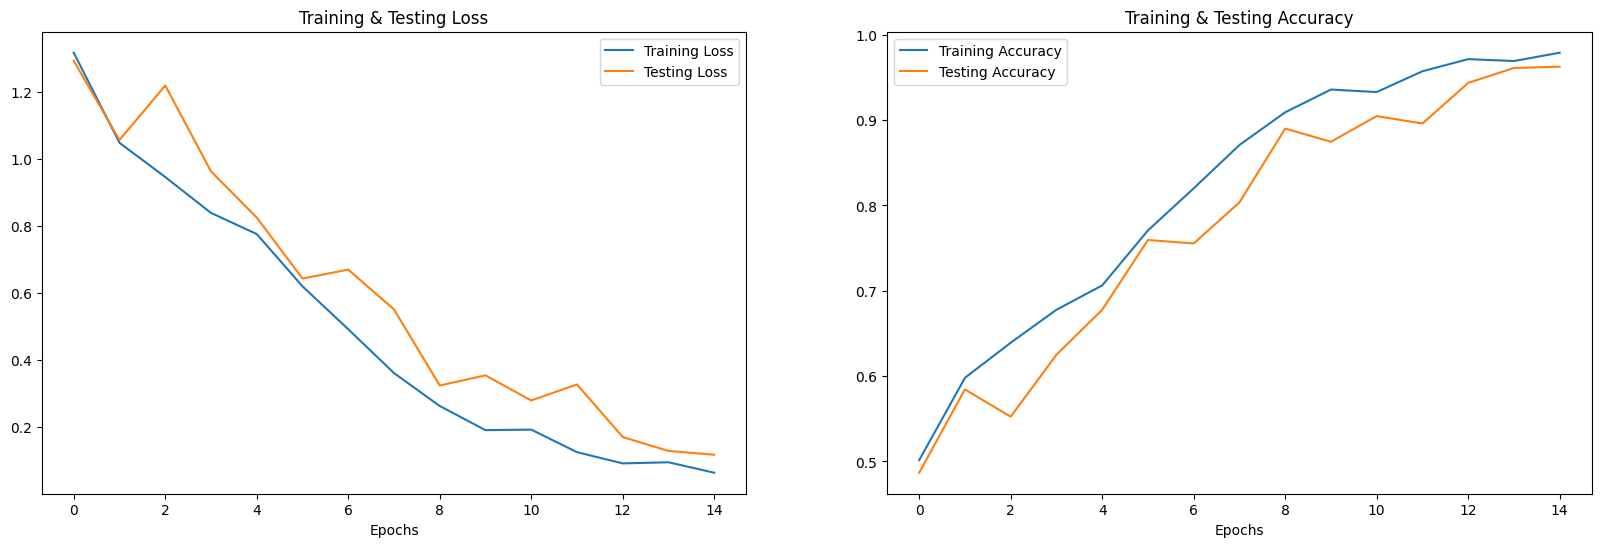

In [39]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")
epochs = [i for i in range(len(history.history['accuracy']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


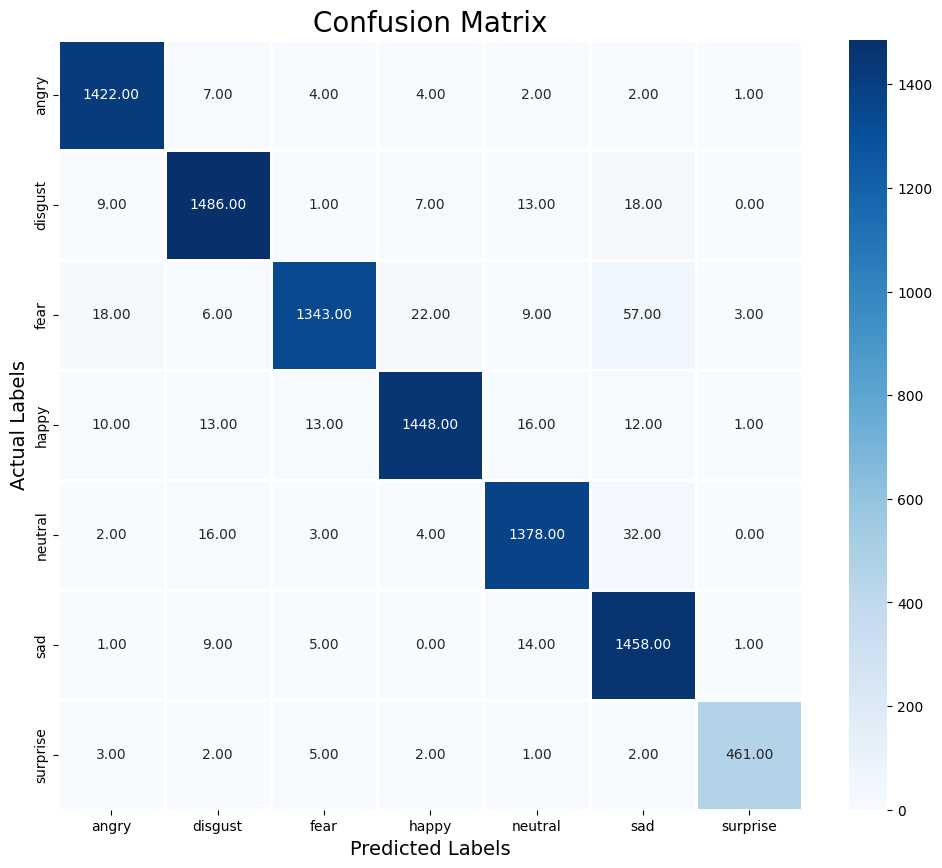

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1442
           1       0.97      0.97      0.97      1534
           2       0.98      0.92      0.95      1458
           3       0.97      0.96      0.97      1513
           4       0.96      0.96      0.96      1435
           5       0.92      0.98      0.95      1488
           6       0.99      0.97      0.98       476

    accuracy                           0.96      9346
   macro avg       0.97      0.96      0.96      9346
weighted avg       0.96      0.96      0.96      9346



In [41]:
from sklearn.metrics import confusion_matrix,classification_report

# Predict on the test set
y_pred = model.predict(x_testcnn)
# Convert predictions to class labels
y_pred0 = np.argmax(y_pred, axis=1)
# Convert true labels to class labels
y_test0 = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))